# Stock Prediction Project



<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables. 


**Data Preprocessing: data preprocessing**




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


df = pd.read_csv("stock.csv")
df.head(10)

,Date,Stock,Oil,EuroToDollar,Gold
0,2015-11-23,2089.409912,41.490002,0.9432,1124.7
1,2015-11-24,2084.419922,42.040001,0.9388,1131.6
2,2015-11-25,2089.300049,42.689999,0.9420,1128.4
3,2015-11-27,2088.820068,43.250000,0.9438,1114.5
4,2015-11-30,2090.949951,41.770000,0.9468,1123.9
5,2015-12-01,2082.929932,41.730000,0.9416,1122.0
6,2015-12-02,2101.709961,41.689999,0.9458,1112.4
7,2015-12-03,2080.709961,40.150002,0.9173,1120.6
8,2015-12-04,2051.239990,41.310001,0.9188,1143.2
9,2015-12-07,2090.419922,40.099998,0.9225,1134.3


In [2]:
# checking for missing values
print(df.isna().sum())

Date             0
Stock            0
Oil             10
EuroToDollar    12
Gold             0
dtype: int64


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


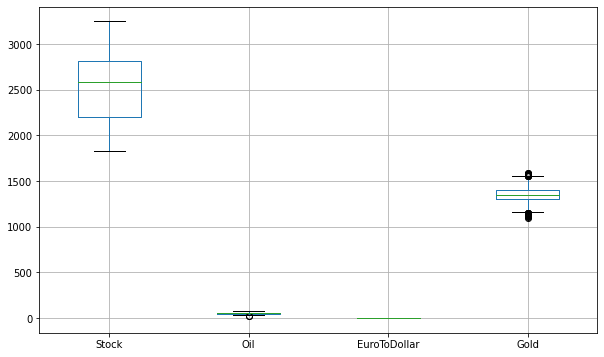

In [3]:
# show boxplots of all features
plt.figure(figsize=(10, 6))
df.boxplot()
plt.show()

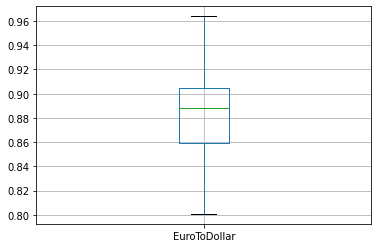

In [4]:
df.boxplot(column=['EuroToDollar']) 

In [5]:
# def encode_cyclic_date(df, date_col):
#     df[date_col] = pd.to_datetime(df[date_col])
#     df['sin_year'] = np.sin(2 * np.pi * df[date_col].dt.year / df[date_col].dt.year.max())
#     df['cos_year'] = np.cos(2 * np.pi * df[date_col].dt.year / df[date_col].dt.year.max())
#     df['sin_month'] = np.sin(2 * np.pi * df[date_col].dt.month / 12)
#     df['cos_month'] = np.cos(2 * np.pi * df[date_col].dt.month / 12)
#     df['sin_day'] = np.sin(2 * np.pi * df[date_col].dt.day / df[date_col].dt.day.max())
#     df['cos_day'] = np.cos(2 * np.pi * df[date_col].dt.day / df[date_col].dt.day.max())
#     return df.drop(date_col, axis=1)

# df_encoded = encode_cyclic_date(df, 'Date')
# df.head(10)

convert the "Date" column into a datetime format and sets it as the index. This allows for easier manipulation of time-based data. Setting the "Date" column as the index of the DataFrame enables easy slicing of data

In [6]:
#providing useful plots to visualize the trends in the data.
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.set_index('Date', inplace=True)

In [7]:
print(df.isna().sum())

Stock            0
Oil             10
EuroToDollar    12
Gold             0
dtype: int64


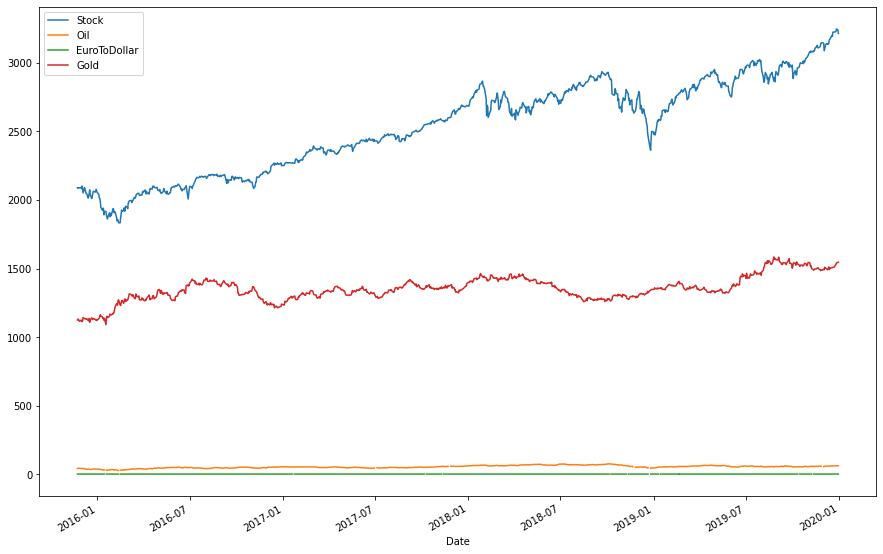

In [8]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df[['Stock', 'Oil', 'EuroToDollar', 'Gold']] = scaler.fit_transform(df[['Stock', 'Oil', 'EuroToDollar', 'Gold']])

df.plot(figsize=(15, 10))
plt.show()


In [9]:
# compute the pairwise correlation of all columns
correlations = df.corr()

# print the correlation matrix
print(correlations)

                 Stock       Oil  EuroToDollar      Gold
Stock         1.000000  0.782072     -0.353939  0.626957
Oil           0.782072  1.000000     -0.478768  0.378061
EuroToDollar -0.353939 -0.478768      1.000000 -0.299537
Gold          0.626957  0.378061     -0.299537  1.000000


In [10]:
# as EuroToDollar has a negative correlation with stock I have dropped it
# this did not have a significant effect on my accuracy however which was already quite high
df = df.drop("EuroToDollar", axis=1)

**Step 2: data cleaning**

There are a number of missing values in the data so we need to clean the data so that it is suitable for use with the NN. Bare in mind we want retain the time coherency of the data as much as possible.


Decided on interpolating missing values because it preserves the time-based structure of the data and provides a more accurate representation of the underlying patterns.

In [11]:
# Use linear interpolation to estimate missing values
df.interpolate(method='linear', inplace=True)
# Check if any missing values still exist
print(df.isna().sum())

Stock    0
Oil      0
Gold     0
dtype: int64


I found that a lower number of time steps provided much better accuracy, this was observed when I switched from 100 to 10, and again when I switched from 10 to 5

In [12]:
time_steps = 5

x = np.array([df.iloc[i:i + time_steps] for i in range(len(df) - time_steps)])
# set up y array to be used to predict stock price one day in the future
y = np.array([df.iloc[i + time_steps:i + time_steps + 1][['Stock']] for i in range(len(df) - time_steps)])
print(x.shape)
print(y.shape)

(1028, 5, 3)
(1028, 1, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

#noramalise the data
x_train_max = x_train.max()
x_train_min = x_train.min()
x_train = (x_train - x_train_min) / (x_train_max - x_train_min)
x_test = (x_test - x_train_min) / (x_train_max - x_train_min)

y_train_max = y_train.max()
y_train_min = y_train.min()
y_train = (y_train - y_train_min) / (y_train_max - y_train_min)
y_test = (y_test - y_train_min) / (y_train_max - y_train_min)

**Step 3: model construction**

Constructing a RNN network that will predict the future value of Stock, one day/time inteval in advance.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.models import Model

# Define the inputs (the time sequence of feature variables)
inputs = Input(shape=(time_steps, df.shape[1]))

# Define a Simple Recurrent Neural Network
n = SimpleRNN(units=10)(inputs)
# add some extra layer to improve accuracy
hidden_layer = Dense(10, activation='linear')(n)
hidden_layer = Dense(20, activation='linear')(hidden_layer)

# Add a final fully connected layer to give us the prediced value
output = Dense(1, activation='linear')(hidden_layer)

# Create a Simple RNN model based upon our inputs and output
simple_rnn = Model(inputs, output, name="simple_rnn")

simple_rnn.compile(loss='mse', optimizer='adam')
simple_rnn.summary()

Model: "simple_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 3)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                140       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [15]:
simple_rnn.fit(x_train, y_train, epochs=1000, batch_size=128,callbacks=[EarlyStopping(monitor='loss', patience=10)])

Epoch 1/1000
7/7 [==============================] - 3s 7ms/step - loss: 0.1739
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0759
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0785
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0554
Epoch 7/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 8/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 9/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 10/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0472
Epoch 11/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0451
Epoch 12/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0429
Epoch 13/1000
7/7 [==============================

**Step 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found deep learning models.


In [16]:
# predictions = simple_rnn.predict(x_test)

# # Convert the predictions back to the original scale
# predictions = scaler.inverse_transform(predictions)

# # Convert the predictions back to a dataframe
# predictions = pd.DataFrame(predictions, columns=['Predicted'], index=test_data.index)
y_predictions = simple_rnn.predict(x_test)
print(y_predictions.shape)

7/7 [==============================] - 0s 5ms/step
(206, 1)


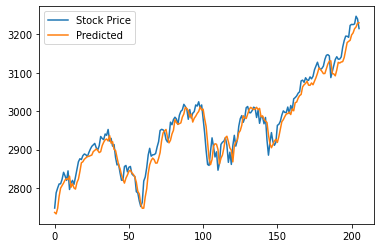

In [17]:
# must de normalise data before evaluating
y_test_denormalized = y_test * (y_train_max - y_train_min) + y_train_min
y_predictions_denormalized = y_predictions * (y_train_max - y_train_min) + y_train_min
y_test_denormalized = y_test_denormalized.reshape(-1,)
y_predictions_denormalized = y_predictions_denormalized.reshape(-1,)
plt.plot(y_test_denormalized, label="Stock Price")
plt.plot(y_predictions_denormalized, label="Predicted")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE, RMSE, and MAE for test set
test_mse = mean_squared_error(y_test_denormalized, y_predictions_denormalized)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_denormalized, y_predictions_denormalized)

# Calculate R-squared for test set
test_r2 = r2_score(y_test_denormalized, y_predictions_denormalized)

# Get the predictions for the training set
y_train_predictions = simple_rnn.predict(x_train)
y_train_denormalized = y_train * (y_train_max - y_train_min) + y_train_min
y_train_denormalized = y_train_denormalized.reshape(-1,)

y_train_predictions_denormalized = y_train_predictions * (y_train_max - y_train_min) + y_train_min
y_train_predictions_denormalized = y_train_predictions_denormalized.reshape(-1,)

# Calculate MSE, RMSE, and MAE for training set
train_mse = mean_squared_error(y_train_denormalized, y_train_predictions_denormalized)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_denormalized, y_train_predictions_denormalized)

# Calculate R-squared for training set
train_r2 = r2_score(y_train_denormalized, y_train_predictions_denormalized)

# Print the evaluation metrics
print("Test Set Metrics:")
print("MSE: ", np.round(test_mse,2))
print("RMSE: ", np.round(test_rmse,2))
print("MAE: ", np.round(test_mae,2))
print("R-squared: ", np.round(test_r2,2))
print()
print("Train Set Metrics:")
print("MSE: ", np.round(train_mse,2))
print("RMSE: ", np.round(train_rmse,2))
print("MAE: ", np.round(train_mae,2))
print("R-squared: ", np.round(train_r2,2))


26/26 [==============================] - 0s 3ms/step
Test Set Metrics:
MSE:  655.92
RMSE:  25.61
MAE:  20.64
R-squared:  0.95

Train Set Metrics:
MSE:  553.31
RMSE:  23.52
MAE:  16.72
R-squared:  0.99


we can see that the model performs better on the training set than the test set. This is expected, as the model has been trained on the training set and has likely overfit to the training data. The difference between the training and test set performance is an indication of overfitting. we can observe that the R-squared values are high for both the training and test sets, meaning it is a well performing model. The high values for MSE, RMSE, and MAE on both datasets indicate that the model is not accuarate enough to make reliable predictions though.


## Sentiment Analysis



### Context

We have a model that predicts the sentiment of a film review (positive or negative) from the IMDB. There are two hyperparameters that format the data from IMDB: the maximum review length and the dictionary size. Below is a RNN model that predicts sentiment values. 



Changing the model so that it uses attention only, i.e. there are no recurrent components, while Keeping top_words, max_review_lenngth and the embedding_vector_length the same. 

In [19]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Embedding, Dropout, Reshape, Lambda, Dot, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

top_words = 100
(Rev_train, Sc_train), (Rev_test, Sc_test) = imdb.load_data(num_words=top_words)

max_review_length = 500
X_train = sequence.pad_sequences(Rev_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(Rev_test, maxlen=max_review_length)
print(X_train.shape)

(25000, 500)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           1600      
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 10)                1080      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,691
Trainable params: 2,691
Non-trainable params: 0
_________________________________________________________________
None


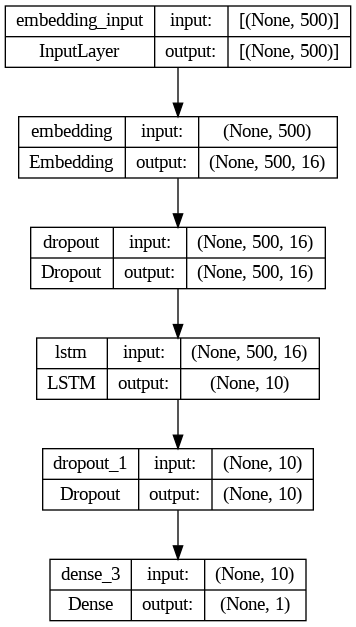

In [20]:
embedding_vector_length = 16
model_imdb = Sequential()
model_imdb.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_imdb.add(Dropout(0.2))
model_imdb.add(LSTM(10))
model_imdb.add(Dropout(0.2))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())
plot_model(model_imdb,show_shapes=True)


The history for the model above has been saved, as it takes a while to run. If you want to run it yourself then comment out the second line.


[]

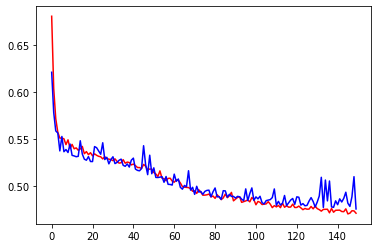

In [21]:
nepoch = 150
#IMDB_history = model_imdb.fit(X_train,Sc_train,validation_data=(X_test,Sc_test),epochs=nepoch,batch_size=256)
IMDB_history=np.load('IMDBTrainhist.npy',allow_pickle='TRUE').item()
plt.plot(range(nepoch),IMDB_history['loss'],c='r')
plt.plot(range(nepoch),IMDB_history['val_loss'],c='b')
plt.plot()

[]

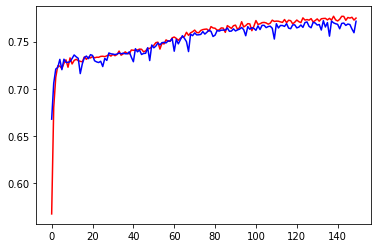

In [22]:
plt.plot(range(nepoch),IMDB_history['accuracy'],c='r')
plt.plot(range(nepoch),IMDB_history['val_accuracy'],c='b')
plt.plot()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 16)      1600        ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 500, 16)      0           ['embedding_1[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 500, 16)      0           ['dropout_2[0][0]']              
                                                                                              

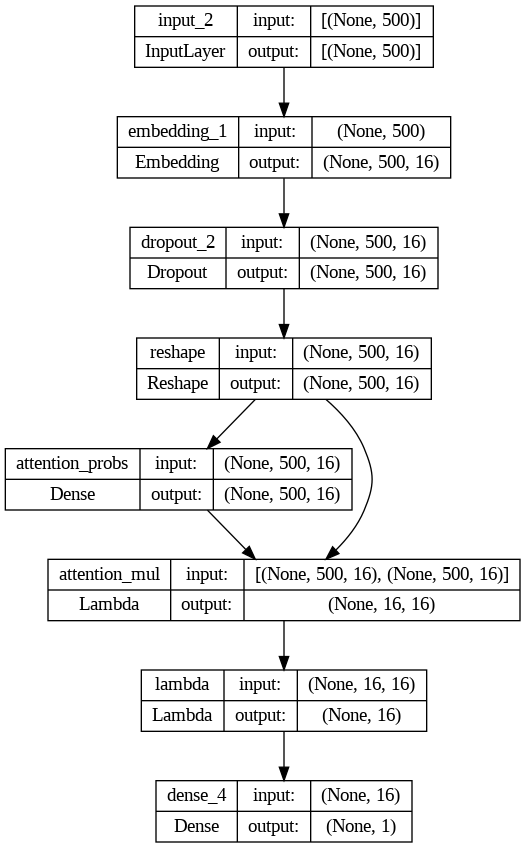

In [23]:
embedding_vector_length = 16
# Define input layer with shape (max_review_length,) and create an Embedding layer
inputs = Input(shape=(max_review_length,))
embedding = Embedding(top_words, embedding_vector_length)(inputs)
# Add a Dropout layer to reduce overfitting
dropout = Dropout(0.3)(embedding)
# Reshape the input to 3D tensor
flatten = Reshape((max_review_length, embedding_vector_length))(dropout)
# Add an attention to the network
# Use a Dense layer with softmax activation to compute attention weights
probability = Dense(embedding_vector_length, activation='softmax', name='probability')(flatten)
#Element-wise multiplication of the attention weights and the input
muliplied = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=1), name='muliplied')([probability, flatten])
#summing the output of the element-wise multiplication
attention_output = Lambda(lambda x: K.sum(x, axis=1))(muliplied)
dense = Dense(1, activation='sigmoid')(attention_output)
attention_model = Model(inputs=inputs, outputs=dense)

# Compile and train the model
attention_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(attention_model.summary())
plot_model(attention_model, show_shapes=True)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# Train the model with early stopping
attention_IMDB_history = attention_model.fit(X_train, Sc_train, validation_data=(X_test, Sc_test),
                          epochs=150, batch_size=256, callbacks=[early_stopping])


Epoch 1/150
98/98 [==============================] - 14s 134ms/step - loss: 0.7718 - accuracy: 0.5881 - val_loss: 0.5892 - val_accuracy: 0.6892
Epoch 2/150
98/98 [==============================] - 13s 130ms/step - loss: 0.5890 - accuracy: 0.6831 - val_loss: 0.5562 - val_accuracy: 0.7190
Epoch 3/150
98/98 [==============================] - 13s 133ms/step - loss: 0.5703 - accuracy: 0.7028 - val_loss: 0.5693 - val_accuracy: 0.6957
Epoch 4/150
98/98 [==============================] - 13s 132ms/step - loss: 0.5681 - accuracy: 0.7080 - val_loss: 0.5507 - val_accuracy: 0.7168
Epoch 5/150
98/98 [==============================] - 13s 129ms/step - loss: 0.5580 - accuracy: 0.7152 - val_loss: 0.5548 - val_accuracy: 0.7191
Epoch 6/150
98/98 [==============================] - 27s 282ms/step - loss: 0.5615 - accuracy: 0.7112 - val_loss: 0.5429 - val_accuracy: 0.7279
Epoch 7/150
98/98 [==============================] - 19s 195ms/step - loss: 0.5581 - accuracy: 0.7142 - val_loss: 0.5616 - val_accuracy:

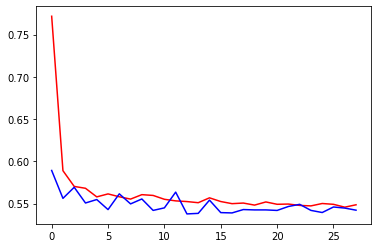

In [25]:
nepoch = len(attention_IMDB_history.epoch)
#IMDB_history = model_imdb.fit(X_train,Sc_train,validation_data=(X_test,Sc_test),epochs=nepoch,batch_size=256)
#IMDB_history=np.load('IMDBTrainhist.npy',allow_pickle='TRUE').item()
plt.plot(range(nepoch), attention_IMDB_history.history['loss'], c='r')
plt.plot(range(nepoch), attention_IMDB_history.history['val_loss'], c='b')
plt.show()


[]

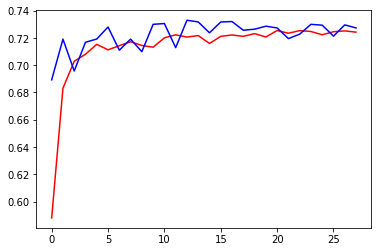

In [26]:
plt.plot(range(nepoch),attention_IMDB_history.history['accuracy'],c='r')
plt.plot(range(nepoch),attention_IMDB_history.history['val_accuracy'],c='b')
plt.plot()

In [27]:
_, atten_train_acc = attention_model.evaluate(X_train, Sc_train, verbose=0)
_, atten_test_acc = attention_model.evaluate(X_test, Sc_test, verbose=0)

print("Attention Train accuracy: %.2f%%" % (atten_train_acc * 100))
print("Attention Test accuracy: %.2f%%" % (atten_test_acc * 100))

Attention Train accuracy: 73.26%
Attention Test accuracy: 72.72%


In [28]:
train_acc = IMDB_history['accuracy']
val_acc = IMDB_history['val_accuracy']

print("Original Train accuracy: %.2f%%" % (train_acc[-1] * 100.0))
print("Original Test accuracy: %.2f%%" % (val_acc[-1] * 100.0))

Original Train accuracy: 77.50%
Original Test accuracy: 77.17%



While the attention model achieved decent accuracy, it did not perform as well as the original RNN model. The original RNN model achieved a higher accuracy on both the train and test sets. Although it must be noted that the attention model was deliberately restricted, so a sensible model was created using attention it just fell 4 or 5 percent behind the RNN in terms of accuracy